
# Transformers in Computer Vision



Transformer architectures owe their origins in natural language processing (NLP), and indeed form the core of the current state of the art models for most NLP applications.

We will now see how to develop transformers for processing image data (and in fact, this line of deep learning research has been gaining a lot of attention in 2021). The *Vision Transformer* (ViT) introduced in [this paper](https://arxiv.org/pdf/2010.11929.pdf) shows how standard transformer architectures can perform very well on image. The high level idea is to extract patches from images, treat them as tokens, and pass them through a sequence of transformer blocks before throwing on a couple of dense classification layers at the very end.


Some caveats to keep in mind: 
- ViT models are very cumbersome to train (since they involve a ton of parameters) so budget accordingly. 
- ViT models are a bit hard to interpret (even more so than regular convnets).
- Finally, while in this notebook we will train a transformer from scratch, ViT models in practice are almost always *pre-trained* on some large dataset (such as ImageNet) before being transferred onto specific training datasets.





# Setup

As usual, we start with basic data loading and preprocessing.

In [16]:
!pip install einops # some package

In [17]:
import torch
from torch import nn
from torch import nn, einsum
import torch.nn.functional as F
from torch import optim

from einops import rearrange, repeat
from einops.layers.torch import Rearrange
import numpy as np
import torchvision
import time

In [18]:
torch.manual_seed(42) # to make sure randomness is deterministic

DOWNLOAD_PATH = '/data/mnist'
BATCH_SIZE_TRAIN = 1000
BATCH_SIZE_TEST = 1000

transform_mnist = torchvision.transforms.Compose([torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  torchvision.transforms.Normalize((0.1307,), (0.3081,))])

train_set = torchvision.datasets.KMNIST(DOWNLOAD_PATH, train=True, download=True,
                                       transform=transform_mnist)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE_TRAIN, shuffle=True)

test_set = torchvision.datasets.KMNIST(DOWNLOAD_PATH, train=False, download=True,
                                      transform=transform_mnist)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE_TEST, shuffle=False)


# The ViT Model



We will now set up the ViT model. There will be 3 parts to this model:

* A *patch embedding* layer that takes an image and tokenizes it. There is some amount of tensor algebra involved here (since we have to slice and dice the input appropriately), and the `einops` package is helpful. We will also add learnable positional encodings as parameters.
* A sequence of transformer blocks. This will be a smaller scale replica of the original proposed ViT, except that we will only use 4 blocks in our model (instead of 32 in the actual ViT).
* A (dense) classification layer at the end.

Further, each transformer block consists of the following components: 

* A *self-attention* layer with $H$ heads, 
* A one-hidden-layer (dense) network to collapse the various heads. For the hidden neurons, the original ViT used something called a [GeLU](https://arxiv.org/pdf/1606.08415.pdf) activation function, which is a smooth approximation to the ReLU. For our example, regular ReLUs seem to be working just fine. The original ViT also used Dropout but we won't need it here.
* *Layer normalization* preceeding each of the above operations.

Some care needs to be taken in making sure the various dimensions of the tensors are matched.

In [19]:
def pair(t):
    return t if isinstance(t, tuple) else (t, t)

# print(pair(3))
# prints (3,3)

# print(pair((3,5,7)))
# prints (3,5,7)

# classes

class PreNorm(nn.Module): # normalizes just before applying the function
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim) # check: https://pytorch.org/docs/stable/generated/torch.nn.LayerNorm.
        # normalized_shape argument is `dim`
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module): # this is the one-hidden-layer network mentioned above, that will collapse various "heads"
     # this is the MLP in Fig.1 https://arxiv.org/pdf/2010.11929.pdf
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.ReLU(), #nn.GELU(), # we will use classical ReLU and no dropouts
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)
   

class Attention(nn.Module): # this is the multi-head attention in Fig.1 https://arxiv.org/pdf/2010.11929.pdf
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads # this is because `heads` will be working in parallel
        project_out = not (heads == 1 and dim_head == dim) # see comment in line 52

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.attend = nn.Softmax(dim = -1) # softmax will be applied to the last dimension
        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential( # dimension reduction operations are done with some NN blocks. 
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()
        # if project_out is false, you just have nn.Identity()
        # if there is only one `head` and `dim`=`inner_dim`, you just return identity


    def forward(self, x):
        # print(x.shape)
        # prints [100, 17, 64]
        # 64 comes from `to_patch_embedding`
        b, n, _, h = *x.shape, self.heads # n = number of patches. in our case (28/7=4)^2 = 16.  
        # +1 comes from extra learnable class embedding in Fig. 1 https://arxiv.org/pdf/2010.11929.pdf
        qkv = self.to_qkv(x).chunk(3, dim = -1) # chunk(3) because of you want to partition it into q, k, v
        # self.to_qkv(x) results in shape [100, 17, 64*8*3], where 64*8=inner_dim
        # qkv consists of 3 tensors of shape [100, 17, 64*8]
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)
        # this is the line that implements multi-head attention so that we run `h` (heads) amount of self-attention operations in parallel

        # print(q.shape)
        # prints [100, 8, 17, 64] since we have `heads`=8.
           
        # matrix multiplication performed as such because you do the matrix multiplication for every pair of (b, h)
        # since every batch and every head is acting in 'orthogonal fashion'

        # follows Eq. 6 in the appendix of https://arxiv.org/pdf/2010.11929.pdf
        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale   
        # to obtain (b, h, i, j) in the results tensor, you iterate over all possible d's and compute q(b,h,i,d)*k(b,h,j,d) and sum them up.
        attn = self.attend(dots)

        # follows Eq. 7 in the appendix of https://arxiv.org/pdf/2010.11929.pdf
        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        # to obtain (b, h, i, d) in the results tensor, you iterate over all possible j's and compute q(b,h,i,j)*k(b,h,j,d) and sum them up.
        # check the dimensions of the above to confirm it corresponds to the matrix summation

        out = rearrange(out, 'b h n d -> b n (h d)') # after parallelization with `heads`, you re-arrange the array
        # so that it has its initial structure (see line 63) as well as the fact that each head contains information from each patch.

        return self.to_out(out)

class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        for _ in range(depth): # depth corresponds to L in Fig.1 https://arxiv.org/pdf/2010.11929.pdf
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout)) # this is the blue block in Fig. 1 RHS
            ]))
    def forward(self, x): # implements Fig. 1 https://arxiv.org/pdf/2010.11929.pdf
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return x

class ViT(nn.Module):
    def __init__(self, *, image_size, patch_size, num_classes, dim, depth, heads, mlp_dim, pool = 'cls', channels = 3, dim_head = 64, dropout = 0., emb_dropout = 0.):
        super().__init__()
        image_height, image_width = pair(image_size)
        patch_height, patch_width = pair(patch_size)

        assert image_height % patch_height == 0 and image_width % patch_width == 0, 'Image dimensions must be divisible by the patch size.'
        # the program crashes if assert statement is not satisfied

        num_patches = (image_height // patch_height) * (image_width // patch_width) # mathematical equation to get num_patches 
        patch_dim = channels * patch_height * patch_width # we have channels=1 in our case.

        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'

        self.to_patch_embedding = nn.Sequential(
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1 = patch_height, p2 = patch_width),
            # obtains h*w amount of patches of size p1*p2*c for every batch, b.
            # in the rest of the functions, h*w=n, i.e. number of patches
            nn.Linear(patch_dim, dim), # nn.Linear output dimensions is `dim` so that it matches the input dimension of Transformer
            # see line 128
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = Transformer(dim, depth, heads, dim_head, mlp_dim, dropout)

        self.pool = pool
        self.to_latent = nn.Identity() # just a placeholder for identity operator

        self.mlp_head = nn.Sequential( # this is the MLP-head in Fig. 1 https://arxiv.org/pdf/2010.11929.pdf
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, img):
        x = self.to_patch_embedding(img)
        # print(x.shape)
        # prints [100, 16, 64] since `dim`=64
        b, n, _ = x.shape # n = h*w, i.e. number of patches, see line 108

        cls_tokens = repeat(self.cls_token, '() n d -> b n d', b = b) # repeat comes from einops: https://einops.rocks/api/repeat/
        # print(cls_tokens.shape)
        # prints [100, 1, 64], where b=100
        x = torch.cat((cls_tokens, x), dim=1)
        # x is now of shape [100, 17, 64], since we know added extra learnable [class] embedding
        x += self.pos_embedding[:, :(n + 1)] 
        x = self.dropout(x)

        x = self.transformer(x)

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0] # since we have a learnable class embedding 

        x = self.to_latent(x)
        return self.mlp_head(x)

In [20]:
model = ViT(image_size=28, patch_size=7, num_classes=10, channels=1, dim=64, depth=4, heads=8, mlp_dim=128)
# image size is 28x28. patch size is 7x7. 28 is divisible by 7 -- expected behaviour.
# we will use 4 blocks in our model, i.e. `depth=4`.
# `channels=1` since we have black-white image.
optimizer = optim.Adam(model.parameters(), lr=0.003)

Let's see how the model looks like.

In [21]:
model

ViT(
  (to_patch_embedding): Sequential(
    (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=7, p2=7)
    (1): Linear(in_features=49, out_features=64, bias=True)
  )
  (dropout): Dropout(p=0.0, inplace=False)
  (transformer): Transformer(
    (layers): ModuleList(
      (0): ModuleList(
        (0): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): Attention(
            (attend): Softmax(dim=-1)
            (to_qkv): Linear(in_features=64, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=64, bias=True)
              (1): Dropout(p=0.0, inplace=False)
            )
          )
        )
        (1): PreNorm(
          (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=64, out_features=128, bias=True)
              (1): ReLU()
              (2): Dropout

This is it -- 4 transformer blocks, followed by a linear classification layer. Let us quickly see how many trainable parameters are present in this model.

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(model))

597002


About half a million. Not too bad; the bigger NLP type models have several tens of millions of parameters. But since we are training on MNIST this should be more than sufficient.

# Training and testing

All done! We can now train the ViT model. The following again is boilerplate code.


In [23]:
def train_epoch(model, optimizer, data_loader, loss_history):
    total_samples = len(data_loader.dataset)
    model.train()

    for i, (data, target) in enumerate(data_loader):
        optimizer.zero_grad()
        output = F.log_softmax(model(data), dim=1) # https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html 
        loss = F.nll_loss(output, target) # https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html. useful for classication problem with C classes
        # as seen in the link above, log_softmax and nll_loss are coupled together...
        # as an alternative to CrossEntropyLoss(), the operations are identical. 
        loss.backward()
        optimizer.step()

        if i % 100 == 0:
            print('[' +  '{:5}'.format(i * len(data)) + '/' + '{:5}'.format(total_samples) +
                  ' (' + '{:3.0f}'.format(100 * i / len(data_loader)) + '%)]  Loss: ' +
                  '{:6.4f}'.format(loss.item()))
            loss_history.append(loss.item())


In [24]:
def evaluate(model, data_loader, loss_history):
    model.eval()
    
    total_samples = len(data_loader.dataset)
    correct_samples = 0
    total_loss = 0

    with torch.no_grad():
        for data, target in data_loader:
            output = F.log_softmax(model(data), dim=1)
            loss = F.nll_loss(output, target, reduction='sum')
            _, pred = torch.max(output, dim=1)
            
            total_loss += loss.item()
            correct_samples += pred.eq(target).sum() # .eq() is to compare 

    avg_loss = total_loss / total_samples
    loss_history.append(avg_loss)
    print('\nAverage test loss: ' + '{:.4f}'.format(avg_loss) +
          '  Accuracy:' + '{:5}'.format(correct_samples) + '/' +
          '{:5}'.format(total_samples) + ' (' +
          '{:4.2f}'.format(100.0 * correct_samples / total_samples) + '%)\n')


The following will take a bit of time (on CPU).  Each epoch should take about 2 to 3 minutes. At the end of training, we should see upwards of 95% test accuracy. 

In [25]:
N_EPOCHS = 20

start_time = time.time()


train_loss_history, test_loss_history = [], []
for epoch in range(1, N_EPOCHS + 1):
    print('Epoch:', epoch)
    train_epoch(model, optimizer, train_loader, train_loss_history)
    evaluate(model, test_loader, test_loss_history)

print('Execution time:', '{:5.2f}'.format(time.time() - start_time), 'seconds')

Epoch: 1
[    0/60000 (  0%)]  Loss: 2.6558

Average test loss: 1.1418  Accuracy: 6296/10000 (62.96%)

Epoch: 2
[    0/60000 (  0%)]  Loss: 0.6073

Average test loss: 0.8478  Accuracy: 7351/10000 (73.51%)

Epoch: 3
[    0/60000 (  0%)]  Loss: 0.4101

Average test loss: 0.6972  Accuracy: 7862/10000 (78.62%)

Epoch: 4
[    0/60000 (  0%)]  Loss: 0.2370

Average test loss: 0.6122  Accuracy: 8145/10000 (81.45%)

Epoch: 5
[    0/60000 (  0%)]  Loss: 0.2327

Average test loss: 0.5737  Accuracy: 8286/10000 (82.86%)

Epoch: 6
[    0/60000 (  0%)]  Loss: 0.1922

Average test loss: 0.5247  Accuracy: 8438/10000 (84.38%)

Epoch: 7
[    0/60000 (  0%)]  Loss: 0.1684

Average test loss: 0.5710  Accuracy: 8370/10000 (83.70%)

Epoch: 8
[    0/60000 (  0%)]  Loss: 0.1724

Average test loss: 0.4867  Accuracy: 8596/10000 (85.96%)

Epoch: 9
[    0/60000 (  0%)]  Loss: 0.1495

Average test loss: 0.5171  Accuracy: 8497/10000 (84.97%)

Epoch: 10
[    0/60000 (  0%)]  Loss: 0.1486

Average test loss: 0.5045  

In [26]:
evaluate(model, test_loader, test_loss_history)


Average test loss: 0.4856  Accuracy: 8758/10000 (87.58%)



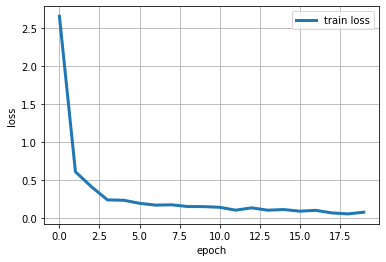

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(range(20),train_loss_history,'-',linewidth=3,label='train loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()

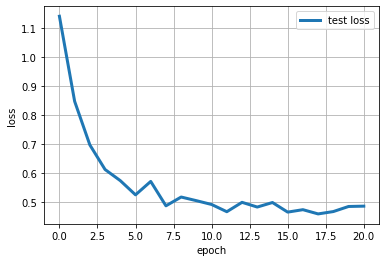

In [29]:
plt.plot(range(21),test_loss_history,'-',linewidth=3,label='test loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()